# Define the helper functions

In [1]:
from scipy.ndimage import convolve
import scipy.ndimage
import torchvision
from skimage.feature import local_binary_pattern
from scipy.spatial import distance
from scipy.stats import chisquare

interactive_fig = None
interactive_fig_styles = None

def plot_images(images, titles, figure_size):
    %matplotlib inline
    if interactive_fig is not None:
        plt.close(interactive_fig)
    if interactive_fig_styles is not None:
        plt.close(interactive_fig_styles)
    plt.figure(figsize=(figure_size, figure_size))
    for i in range(len(images)):
        image = images[i]
        title = titles[i]
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')

def resize_to(image, target):
    target_height, target_width = target.shape[:2]
    image = cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_LINEAR)
    return image

def regenerate(org_image, masked_image, mask):
    if isinstance(mask, torch.Tensor):
        mask = mask.squeeze().cpu().numpy().astype(np.uint8) * 255
        mask = cv2.resize(mask, (org_image.shape[1], org_image.shape[0]), interpolation=cv2.INTER_NEAREST)
        mask = mask.astype(np.uint8)
        
    inverse_mask = cv2.bitwise_not(mask)
    masked_original = cv2.bitwise_and(org_image, org_image, mask=inverse_mask)
    styled_masked = cv2.bitwise_and(masked_image, masked_image, mask=mask)
    return cv2.add(masked_original, styled_masked) 

def plot_tensor_image(tensor):
    if tensor.is_cuda:
        tensor = tensor.cpu()
    
    tensor = tensor.detach()
    
    if tensor.dim() == 4 and tensor.size(0) == 1 and tensor.size(1) == 1:
        tensor = tensor.squeeze(0).squeeze(0)  
        plt.imshow(tensor.numpy(), cmap='gray')
    elif tensor.dim() == 3 and tensor.size(0) == 1:
        tensor = tensor.squeeze(0)
        plt.imshow(tensor.numpy(), cmap='gray')
    elif tensor.dim() == 3 and tensor.size(0) in [1, 3]:
        tensor = tensor.permute(1, 2, 0).numpy()
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min()) 
        plt.imshow(tensor)
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor.shape}")

    plt.axis('off')  # Hide axis
    plt.show()

def extract_borders(mask, border_thickness, border_type='inner'):
    binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]
    
    kernel = np.ones((border_thickness, border_thickness), np.uint8)
    
    if border_type == 'inner':
        # Erode the mask for inner borders
        eroded_mask = cv2.erode(binary_mask, kernel, iterations=1)
        border_mask = binary_mask - eroded_mask
    elif border_type == 'outer':
        # Dilate the mask for outer borders
        dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)
        border_mask = dilated_mask - binary_mask
    elif border_type == 'both':
        # Extract both inner and outer borders
        eroded_mask = cv2.erode(binary_mask, kernel, iterations=1)
        inner_border_mask = binary_mask - eroded_mask
        
        dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)
        outer_border_mask = dilated_mask - binary_mask
        
        # Combine inner and outer borders
        border_mask = cv2.bitwise_or(inner_border_mask, outer_border_mask)
    else:
        raise ValueError("border_type must be either 'inner', 'outer', or 'both'")
    
    return border_mask

def apply_border_mask(image, mask, border_thickness, border_type='inner'):
    border_mask = extract_borders(mask, border_thickness, border_type=border_type)
    border_mask_3channel = cv2.merge([border_mask]*3)
    border_extracted_image = cv2.bitwise_and(image, border_mask_3channel)
    return border_extracted_image

#def penetrate_mask(mask, radius, operation='expand'):
#    if mask.max() > 1:
#        mask = mask / 255.0
#
#    if mask.dim() == 2:  # If the mask is [H, W]
#        mask = mask.unsqueeze(0).unsqueeze(0)  # Make it [1, 1, H, W]
#    elif mask.dim() == 3:  # If the mask is [C, H, W]
#        mask = mask.unsqueeze(0)  # Make it [1, C, H, W]
#
#    mask_np = mask.squeeze(0).cpu().numpy()  # Assuming the mask is [1, H, W]
#    if operation == 'shrink':
#        mask_np = 1 - mask_np
#
#    distance_map = scipy.ndimage.distance_transform_edt(mask_np == 0)
#
#    if operation == 'expand':
#        penetration_mask_np = np.clip((radius - distance_map) / radius, 0, 1)
#    elif operation == 'shrink':
#        penetration_mask_np = np.clip((distance_map - radius) / radius, 0, 1)
#
#    penetration_mask = torch.tensor(penetration_mask_np, device=mask.device, dtype=mask.dtype).unsqueeze(0)
#    return penetration_mask
    
def penetrate_mask(mask, radius, shrink=0):
    import scipy.ndimage 
    import numpy as np

    mask = mask.float()
    mask_np = mask.squeeze(0).cpu().numpy() 

    if shrink > 0:
        eroded_mask_np = scipy.ndimage.binary_erosion(mask_np, iterations=shrink).astype(mask_np.dtype)
    else:
        eroded_mask_np = mask_np

    distance_map = scipy.ndimage.distance_transform_edt(eroded_mask_np == 0)
    penetration_mask_np = np.clip((radius - distance_map) / radius, 0, 1)
    penetration_mask = torch.tensor(penetration_mask_np, device=mask.device, dtype=mask.dtype).unsqueeze(0)
    return penetration_mask 


def get_mask_borders(mask, inside_pixels, outside_pixels):
    mask = (mask > 0).astype(np.uint8)
    inside_eroded = cv2.erode(mask, np.ones((inside_pixels, inside_pixels), np.uint8)) if inside_pixels > 0 else mask
    outside_dilated = cv2.dilate(mask, np.ones((outside_pixels, outside_pixels), np.uint8)) if outside_pixels > 0 else mask
    border_mask = outside_dilated - inside_eroded
    return border_mask

def calculate_gradient_magnitude_around_border(image, mask):
    if len(mask.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    mask = (mask > 0).astype(np.uint8)
    
    grad_magnitudes = []
    for c in range(3): 
        grad_x = cv2.Sobel(image[:, :, c], cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image[:, :, c], cv2.CV_64F, 0, 1, ksize=3)
        grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        grad_magnitudes.append(grad_magnitude)
    
    # Combine gradient magnitudes across channels
    gradient_magnitude = np.mean(grad_magnitudes, axis=0)
    
    # Apply the mask to isolate the border
    border_gradient_magnitude = gradient_magnitude * mask
    border_pixels = border_gradient_magnitude[mask > 0]

    mean_gradient = np.mean(border_pixels)
    std_gradient = np.std(border_pixels)
    median_gradient = np.median(border_pixels)
    return mean_gradient, std_gradient, median_gradient

def calculate_texture_continuity(blended_image, inner_border_mask, outer_border_mask, radius=1, n_points=8):
    # Ensure masks are binary
    inner_border_mask = (inner_border_mask > 0).astype(np.uint8)
    outer_border_mask = (outer_border_mask > 0).astype(np.uint8)
    
    lbp_histograms_inner = []
    lbp_histograms_outer = []
    
    # Process each color channel
    for c in range(3):  # For each color channel (assuming BGR format)
        channel_image = blended_image[:, :, c]
        lbp_image = local_binary_pattern(channel_image, n_points, radius, method='uniform')
        
        # Extract LBP values within the inner and outer masks
        inner_area = lbp_image[inner_border_mask > 0]
        outer_area = lbp_image[outer_border_mask > 0]
        
        # Calculate histograms for each channel
        bins = np.arange(0, n_points + 3)
        inner_hist, _ = np.histogram(inner_area, bins=bins)
        outer_hist, _ = np.histogram(outer_area, bins=bins)
        
        lbp_histograms_inner.append(inner_hist)
        lbp_histograms_outer.append(outer_hist)
    
    # Combine histograms from all channels
    inner_hist_total = np.concatenate(lbp_histograms_inner)
    outer_hist_total = np.concatenate(lbp_histograms_outer)
    
    # Normalize histograms
    eps = 1e-10
    inner_hist_total = inner_hist_total.astype(np.float32)
    outer_hist_total = outer_hist_total.astype(np.float32)
    inner_hist_total /= (inner_hist_total.sum() + eps)
    outer_hist_total /= (outer_hist_total.sum() + eps)
    
    # Compute Chi-square distance
    chi2_distance = 0.5 * np.sum(((inner_hist_total - outer_hist_total) ** 2) / (inner_hist_total + outer_hist_total + eps))
    
    return chi2_distance

In [2]:
#from libs.Matrix_masked import MulLayer as MulLayer_m
#from libs.models_masked import encoder4 as encoder_m, decoder4 as decoder_m
#
#enc_ref_m = encoder_m()
#dec_ref_m = decoder_m()
#matrix_ref_m = MulLayer_m('r41')
#
#enc_ref_m.load_state_dict(torch.load('models/vgg_r41.pth'))
#dec_ref_m.load_state_dict(torch.load('models/dec_r41.pth'))
#matrix_ref_m.load_state_dict(torch.load('models/r41.pth',map_location=torch.device('cpu')))
#
#
#def masked_style_transfer(content, style, mask):
#    with torch.no_grad():
#        cF_ref,small_mask = enc_ref_m(content_im,masked_im)
#        sF_ref,_ = enc_ref_m(style_im)
#        feature_ref,transmatrix_ref = matrix_ref_m(cF_ref['r41'],sF_ref['r41'],small_mask)
#        result = dec_ref_m(feature_ref,masked_im)
#        
#    return result

# Define the algorithm functions

In [18]:
import os
import subprocess

from libs import Matrix, models, Matrix_masked, models_masked
from libs.Matrix import MulLayer
from libs.models import encoder4, decoder4
from libs.Matrix_masked import MulLayer as MulLayer_m
from libs.models_masked import encoder4 as encoder_m, decoder4 as decoder_m

import os
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch.nn as nn

def generateSmallMask(x, mask):
    b, c, h, w = x.shape
    small_mask = mask
    small_mask = torch.nn.functional.interpolate(small_mask, size=(h, w), mode='bilinear', align_corners=False)
    return small_mask.squeeze(0)

def gramMatrix(features):
    # Assumes flattened input
    b, c, l = features.size()
    G = torch.bmm(features,features.transpose(1,2)) # f: bxcx(hxw), f.transpose: bx(hxw)xc -> bxcxc
    return G.div_(c*l)

def styleLoss(features,target,mask):
    ib,ic,ih,iw = features.size()
    iF = features.view(ib,ic,-1)
    imask = mask.view(ib,1,-1)
    iF = iF.masked_select(imask.expand_as(iF) > 0)
    iF = iF.view(ib, ic, -1)
    iMean = torch.mean(iF,dim=2)
    iCov = gramMatrix(iF)

    tb,tc,th,tw = target.size()
    tF = target.view(tb,tc,-1)
    tMean = torch.mean(tF,dim=2)
    tCov = gramMatrix(tF)

    loss = torch.nn.MSELoss(reduction="sum")(iMean,tMean) + torch.nn.MSELoss(reduction="sum")(iCov,tCov)
    return loss/tb

def image_to_tensor(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = F.to_tensor(image)
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor

def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)
    image = tensor.detach().cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    image = (image * 255).clip(0, 255).astype(np.uint8)
    return image

enc_ref = encoder4()
dec_ref = decoder4()
matrix_ref = MulLayer('r41')

enc_ref.load_state_dict(torch.load('./models/vgg_r41.pth'))
dec_ref.load_state_dict(torch.load('./models/dec_r41.pth'))
matrix_ref.load_state_dict(torch.load('./models/r41.pth',map_location=torch.device('cpu')))

def style_transfer(content_im, style_im):
    with torch.no_grad():
        cF_ref = enc_ref(image_to_tensor(content_im))
        sF_ref = enc_ref(image_to_tensor(style_im))
        feature_ref, transmatrix_ref = matrix_ref(cF_ref['r41'], sF_ref['r41'])
        result = dec_ref(feature_ref)
    return tensor_to_image(result)


enc_ref_m = encoder_m()
enc_ref_m_wo = encoder_m()
dec_ref_m = decoder_m()
matrix_ref_m = MulLayer_m('r41')

enc_ref_m.load_state_dict(torch.load('models/vgg_r41.pth'))
enc_ref_m_wo.load_state_dict(torch.load('models/vgg_r41.pth'))
dec_ref_m.load_state_dict(torch.load('models/dec_r41.pth'), strict=False)
matrix_ref_m.load_state_dict(torch.load('models/r41.pth', map_location=torch.device('cpu')))

def partial_convolution(content_im, mask, style_image_file, original_feature_sum=True, feathering=True, penetrate_initial_mask_pixels=0, cookie_cutter=False):
    def blend_styled_edges(original_image, styled_image, mask, alpha=0.5):
        if isinstance(mask, torch.Tensor):
            mask = mask.squeeze().cpu().numpy()

        if mask.shape[:2] != original_image.shape[:2]:
            mask = cv2.resize(mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

        if len(mask.shape) == 3 and mask.shape[2] == 1:
            mask = mask.squeeze(axis=2)
        elif len(mask.shape) == 3 and mask.shape[2] != 1:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        elif len(mask.shape) != 2:
            raise ValueError("Mask must be 2D or 3D with one channel.")

        if mask.max() <= 1:
            mask = (mask * 255).astype(np.uint8)
        else:
            mask = mask.astype(np.uint8)

        original_image = original_image.astype(np.uint8)
        styled_image = styled_image.astype(np.uint8)
        
        
        inverse_mask = cv2.bitwise_not(mask)

        inverse_masked_original = cv2.bitwise_and(original_image, original_image, mask=inverse_mask)
        inverse_masked_original_bordered = apply_border_mask(inverse_masked_original, inverse_mask, 5, border_type='inner')

        masked_styled = cv2.bitwise_and(styled_image, styled_image, mask=mask)
        inverse_masked_styled = cv2.bitwise_and(styled_image, styled_image, mask=inverse_mask)
        masked_styled_outer = apply_border_mask(inverse_masked_styled, mask, 5, border_type='outer')

        blended_image = cv2.addWeighted(masked_styled_outer, alpha, inverse_masked_original_bordered, 1 - alpha, 0)
        blended_image += inverse_masked_original - inverse_masked_original_bordered
        blended_image += masked_styled

        return blended_image

    
    masked_im = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    style_im = cv2.imread(style_image_file)
    
    with torch.no_grad():
        content_tensor = image_to_tensor(content_im)
        style_tensor = image_to_tensor(style_im)

        mask_tensor = image_to_tensor(masked_im)
        mask_tensor = mask_tensor[:, 0:1, :, :]
        
        if penetrate_initial_mask_pixels > 0:
            cF_ref, small_mask = enc_ref_m(content_tensor, penetrate_mask(mask_tensor, penetrate_initial_mask_pixels), cookie_cutter=cookie_cutter)
        else:
            cF_ref, small_mask = enc_ref_m(content_tensor, mask_tensor, cookie_cutter=cookie_cutter)
                
        if original_feature_sum:
            cF_ref_orig, _ = enc_ref_m_wo(content_tensor, cookie_cutter=cookie_cutter)
        else:
            cF_ref_orig = None
        sF_ref, _ = enc_ref_m(style_tensor)
        
        feature_ref, _ = matrix_ref_m(cF_ref['r41'], sF_ref['r41'], small_mask)
        
        result, mask_conv11, mask_conv12, mask_conv13, mask_conv14, mask_conv15, mask_conv16, mask_conv17, mask_conv18, mask_conv19, out11, out12, out13, out14, out15, out16, out17, out18, out19 = dec_ref_m(feature_ref, small_mask, original_features=cF_ref_orig, feathering=feathering, cookie_cutter=cookie_cutter)
        
    processed_image_rgb = tensor_to_image(result)
    processed_image_rgb = resize_to(processed_image_rgb, content_im)
    if feathering:
        processed_image_rgb = blend_styled_edges(cv2.cvtColor(content_im, cv2.COLOR_BGR2RGB), processed_image_rgb, mask, alpha=0.5)
    else:
        processed_image_rgb = regenerate(cv2.cvtColor(content_im, cv2.COLOR_BGR2RGB), processed_image_rgb, mask)
    
    print_style_loss(processed_image_rgb, sF_ref, mask_tensor, style_layers=['r11', 'r21', 'r31', 'r41'])
    
    return processed_image_rgb

def print_style_loss(processed_image_rgb, sF_ref, mask_tensor, style_layers=['r11', 'r21', 'r31', 'r41']):
    total_style_loss = 0.0  
    image_tensor = image_to_tensor(processed_image_rgb)  
    tF, _ = enc_ref_m(image_tensor, mask_tensor) 
    
    for layer in style_layers:
        sf_i = sF_ref[layer].detach()
        tf_i = tF[layer]
        small_mask = generateSmallMask(tf_i, mask_tensor)
        total_style_loss += styleLoss(tf_i, sf_i, small_mask)

    print("Total Style Loss:", total_style_loss.item())

def partial_convolution_feathering(content_im, mask, style_image_file):
    masked_im = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    style_im = cv2.imread(style_image_file)
    
    with torch.no_grad():
        # Convert images to tensors
        content_tensor = image_to_tensor(content_im)
        style_tensor = image_to_tensor(style_im)
        mask_tensor = image_to_tensor(masked_im)
        mask_tensor = mask_tensor[:, 0:1, :, :]  # Ensure mask has one channel

        # **Create a feathered mask that blends inside the masked area**
        mask_np = mask_tensor.cpu().numpy()[0, 0] 

        # Apply Gaussian blur directly to the mask to feather the inside edges
        feathered_mask_np = cv2.GaussianBlur(mask_np, (21, 21), sigmaX=10, sigmaY=10)
        feathered_mask_np = np.clip(feathered_mask_np, 0, 1)
        feathered_mask_tensor = torch.from_numpy(feathered_mask_np).unsqueeze(0).unsqueeze(0).to(content_tensor.device)

        # **Encode the masked content features**
        cF_ref_masked, _ = enc_ref_m(content_tensor, mask_tensor)
        sF_ref, _ = enc_ref_m(style_tensor)

        _, _, h_feat, w_feat = cF_ref_masked['r41'].size()
        feathered_mask_resized = nn.functional.interpolate(feathered_mask_tensor, size=(h_feat, w_feat), mode='bilinear', align_corners=False)
        feathered_mask_resized = torch.clamp(feathered_mask_resized, 0, 1)
                
        def visualize_mask(mask_tensor, title="Mask Visualization"):
            mask_np = mask_tensor.cpu().numpy()
            mask_np = mask_np.squeeze() 
            plt.figure(figsize=(6,6))
            plt.imshow(mask_np, cmap='gray')
            plt.title(title)
            plt.axis('off')
            plt.show()

        visualize_mask(feathered_mask_resized, "Feathered Mask Resized")
        visualize_mask(mask_tensor, "mask_tensor")
        
        # **Style the content features**
        feature_ref, transmatrix_ref = matrix_ref_m(cF_ref_masked['r41'], sF_ref['r41'], feathered_mask_resized)

        # **Run the unmasked content features through the encoder again**
        cF_unmasked, _ = enc_ref_m(content_tensor)
        
        # **Blend the features using the feathered mask**
        blended_feature = cF_unmasked['r41'] * (1 - feathered_mask_resized) + feature_ref * feathered_mask_resized

        # **Run the blended features through the decoder**
        result = dec_ref_m(blended_feature)

    processed_image_rgb = tensor_to_image(result)
    processed_image_rgb = resize_to(processed_image_rgb, content_im)
    #processed_image_rgb = regenerate(cv2.cvtColor(content_im, cv2.COLOR_BGR2RGB), processed_image_rgb, mask)
    
    total_style_loss = 0.0  
    style_layers = ['r11', 'r21', 'r31', 'r41']
    image_tensor = image_to_tensor(processed_image_rgb)  

    # **Compute style loss with the resized feathered mask**
    for layer in style_layers:
        sf_i = sF_ref[layer].detach()
        tf_i = enc_ref_m(image_tensor)[0][layer]

        # Resize the feathered mask to match the current layer's feature map size
        _, _, h_feat, w_feat = tf_i.size()
        feathered_mask_resized = nn.functional.interpolate(feathered_mask_tensor, size=(h_feat, w_feat), mode='bilinear', align_corners=False)
        feathered_mask_resized = torch.clamp(feathered_mask_resized, 0, 1)
        
        total_style_loss += styleLoss(tf_i, sf_i, feathered_mask_resized)
    print("Total Style Loss:", total_style_loss.item())

    return processed_image_rgb


def style_and_mask(image, mask, style_image_file):
    # Perform style transfer
    styled_image = style_transfer(image, cv2.imread(style_image_file))
    
    # Resize the styled image to the original size    
    org_styled_image = resize_to(styled_image, image)
    
    # Regenerate the final output with the mask applied
    final_image = regenerate(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), org_styled_image, mask)
    
    # Compute style loss as MSE between style features and processed image features
    total_style_loss = 0.0
    style_layers = ['r11', 'r21', 'r31', 'r41']
    
    content_tensor = image_to_tensor(image)  
    style_tensor = image_to_tensor(cv2.imread(style_image_file))
    final_tensor = image_to_tensor(final_image)
    mask_tensor = image_to_tensor(mask)[:, 0:1, :, :]  # Assuming the mask is single-channel

    cF_ref, _ = enc_ref_m(content_tensor, mask_tensor)
    sF_ref, _ = enc_ref_m(style_tensor)
    tF, _ = enc_ref_m(final_tensor, mask_tensor)

    for layer in style_layers:
        sf_i = sF_ref[layer]
        sf_i = sf_i.detach()  # Detach to avoid computing gradients here
        tf_i = tF[layer]

        # Resize the feature maps to match the smaller one if they don't match
        if tf_i.size() != sf_i.size():
            target_size = (min(tf_i.size(2), sf_i.size(2)), min(tf_i.size(3), sf_i.size(3)))
            tf_i = torch.nn.functional.interpolate(tf_i, size=target_size, mode='bilinear', align_corners=False)
            sf_i = torch.nn.functional.interpolate(sf_i, size=target_size, mode='bilinear', align_corners=False)

        # Generate the small mask
        small_mask = generateSmallMask(tf_i, mask_tensor)
        
        # Calculate the style loss using the mask
        total_style_loss += styleLoss(tf_i, sf_i, small_mask)
    
    print("Total Style Loss:", total_style_loss.item())
    
    return final_image

def mask_and_style(image, mask, style_image_file):
    masked_image_file = './output/masked.jpg'
    masked_styled_image_file = './output/masked-styled.jpg'
    
    ### mask the original image
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    ### style the masked image
    masked_styled_image = style_transfer(masked_image, cv2.imread(style_image_file))
    
    ### resize styled image to original size    
    resized_masked_styled_image = resize_to(masked_styled_image, image)

    ### regenerating masked-style image
    return regenerate(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), resized_masked_styled_image, mask)

def bbox_mask_and_style(image, mask, style_image_file):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    bboxed_image_file = './output/bboxed-masked.jpg'
    bboxed_styled_image_file = './output/bboxed-masked-style.jpg'

    bbox = masks[mask_index]['bbox']

    ### bbox and mask the original image
    x, y, w, h = bbox
    bboxed_mask = mask[y:y+h, x:x+w]
    original_bboxed_image = image[y:y+h, x:x+w]
    masked_bboxed_image = cv2.bitwise_and(original_bboxed_image, original_bboxed_image, mask=bboxed_mask)
    
    ### style the bboxed image
    bboxed_styled_image = style_transfer(masked_bboxed_image, cv2.imread(style_image_file))
    
    ### resize masked styled image
    bboxed_styled_image = cv2.resize(bboxed_styled_image, (w, h))
    masked_styled_bboxed_image = cv2.bitwise_and(bboxed_styled_image, bboxed_styled_image, mask=bboxed_mask)

    ### regenerating bboxed styles original image
    inverse_mask = cv2.bitwise_not(bboxed_mask)
    masked_original_bboxed_image = cv2.bitwise_and(original_bboxed_image, original_bboxed_image, mask=inverse_mask)
    
    final_bboxed_masked_styled_image = cv2.add(masked_styled_bboxed_image, masked_original_bboxed_image) 
    
    ### inject styled bboxed image into original image
    bbox_masked_styled_image = cv2.cvtColor(cv2.imread(original_image_name), cv2.COLOR_BGR2RGB)
    bbox_masked_styled_image[y:y+h, x:x+w] = final_bboxed_masked_styled_image 
    return bbox_masked_styled_image

def bbox_style_and_mask(image, mask, style_image_file):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    bboxed_image_file = './output/bboxed-masked.jpg'
    bboxed_styled_image_file = './output/bboxed-styled-masked.jpg'

    bbox = masks[mask_index]['bbox']
    x, y, w, h = bbox
    original_bboxed_image = image[y:y+h, x:x+w]
    bboxed_mask = mask[y:y+h, x:x+w]

    ### style the bboxed image
    bboxed_styled_image = style_transfer(original_bboxed_image, cv2.imread(style_image_file))
    
    ### mask the styled bboxed image
    bboxed_styled_image = cv2.resize(bboxed_styled_image, (w, h))
    bboxed_styled_masked_image = cv2.bitwise_and(bboxed_styled_image, bboxed_styled_image, mask=bboxed_mask)
    
    ### regenerating bboxed styles original image
    inverse_mask = cv2.bitwise_not(bboxed_mask)
    masked_original_bboxed_image = cv2.bitwise_and(original_bboxed_image, original_bboxed_image, mask=inverse_mask)
    final_bboxed_masked_styled_image = cv2.add(masked_original_bboxed_image, bboxed_styled_masked_image) 
    
    ### inject styled bboxed image into original image
    bbox_masked_styled_image = cv2.cvtColor(cv2.imread(original_image_name), cv2.COLOR_BGR2RGB)
    bbox_masked_styled_image[y:y+h, x:x+w] = final_bboxed_masked_styled_image 
    return bbox_masked_styled_image
    

# Define the variables

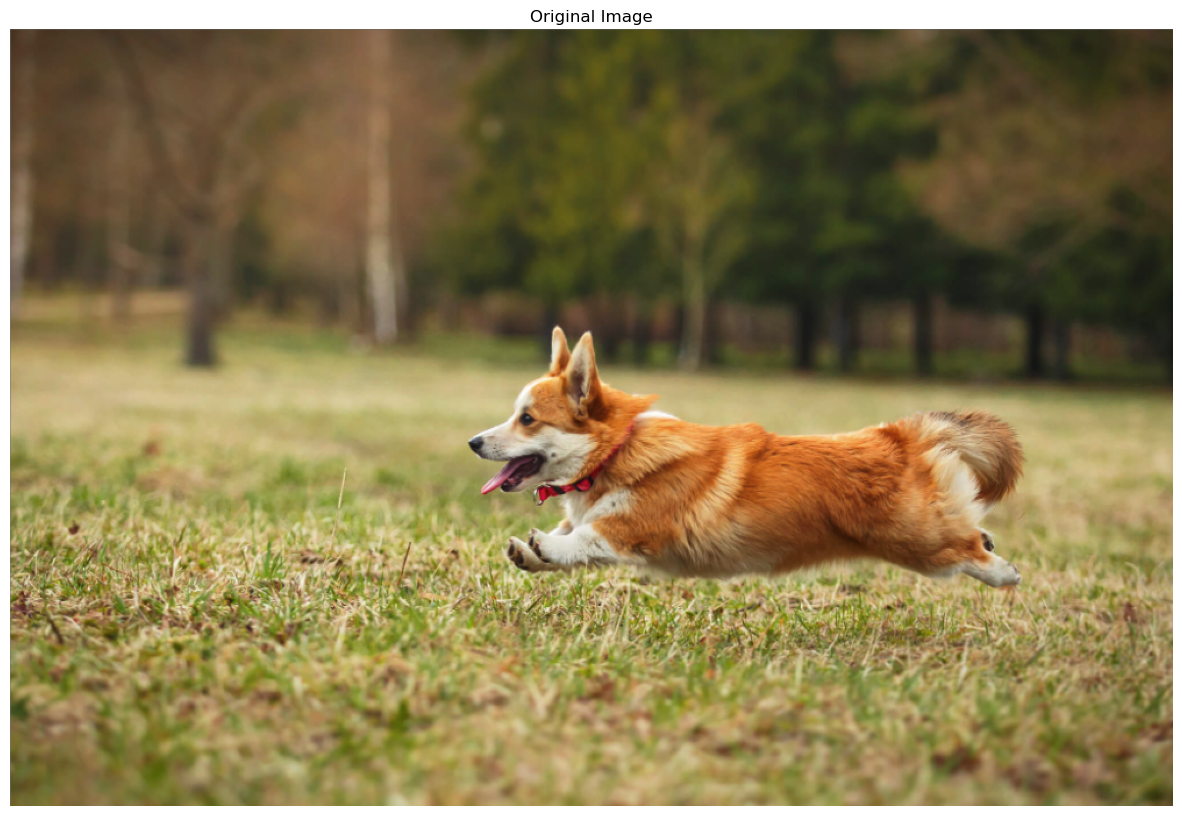

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

linear_style_transfer_file = '/Users/ayberk.cansever/Documents/ECU/Thesis/LinearStyleTransfer/linearstyletransfer.py'
original_image_name = './sources/image-5.png'

image = cv2.imread(original_image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plot_images([image], ['Original Image'], 15)


# Create SAM mask generator

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device=torch.device('mps' if torch.cuda.is_available() else 'cpu')
print(device)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

cpu


# Create masks

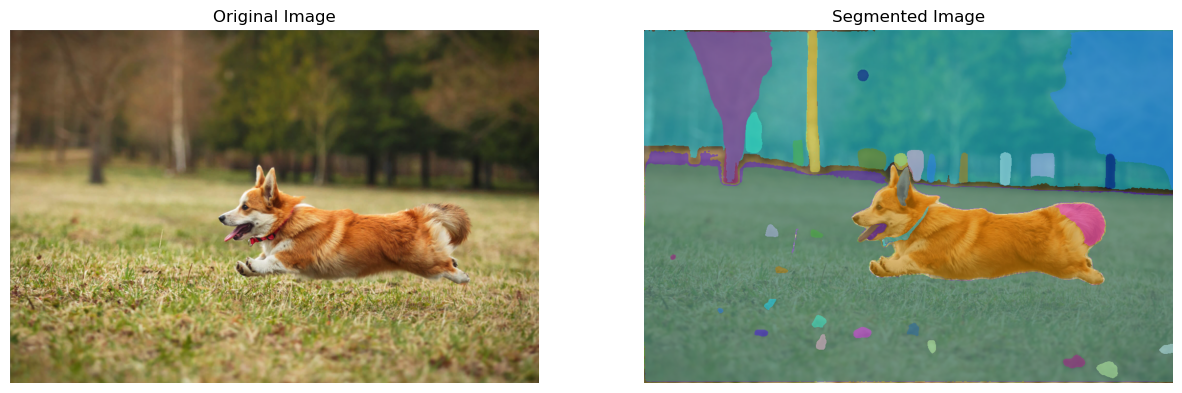

In [6]:
import pickle
import supervision as sv

#masks = mask_generator.generate(image)
#with open('masks-image-10.pkl', 'wb') as file:
#    pickle.dump(masks, file)
#print(masks[0].keys())

with open('masks-image-5.pkl', 'rb') as file:
    masks = pickle.load(file)

segmented_masks = [
    mask['segmentation']
    for mask in masks
]

mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(sam_result=masks)

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
plot_images([image, annotated_image], ['Original Image', 'Segmented Image'], 15)

# Select Mask

Button(description='Save Selected Mask', style=ButtonStyle())

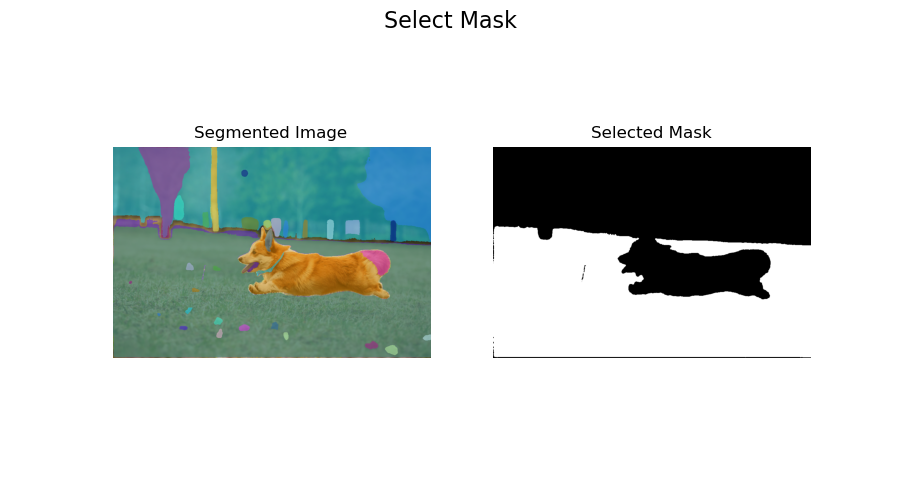

In [7]:
%matplotlib widget
import matplotlib.pyplot as plt
import ipympl


import numpy as np
import cv2
import ipywidgets as widgets

mask_index = 0
mask = (segmented_masks[mask_index] * 255).astype(np.uint8) 

interactive_fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
interactive_fig.suptitle('Select Mask', fontsize=16)

implot1 = ax1.imshow(annotated_image)
ax1.set_title('Segmented Image')
ax1.axis('off')
implot2 = ax2.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
ax2.set_title('Selected Mask')
ax2.axis('off')

def onclick(event):
    global mask 
    global mask_index
    if event.xdata is not None and event.ydata is not None:
        x = int(event.xdata)
        y = int(event.ydata)
        pixel_value = annotated_image[y, x]
        for index, segmented_mask in enumerate(segmented_masks):
            new_mask = (segmented_mask * 255).astype(np.uint8)
            pixel_value = new_mask[y, x]
            if pixel_value == 255:
                mask = (segmented_masks[index] * 255).astype(np.uint8) 
                #mask = np.ones_like(segmented_masks[index], dtype=np.uint8) * 255
                mask_index = index
                implot2.set_data(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
                interactive_fig.canvas.draw_idle()
                break

implot1.figure.canvas.mpl_connect('button_press_event', onclick)

save_button = widgets.Button(description="Save Selected Mask")

# Define the callback function
def on_save_clicked(b):
    filename = f"selected_mask_{mask_index}.png"
    cv2.imwrite(filename, mask)
    print(f"Mask saved as {filename}")

# Link button to callback
save_button.on_click(on_save_clicked)

# Display the button in the notebook
display(save_button)


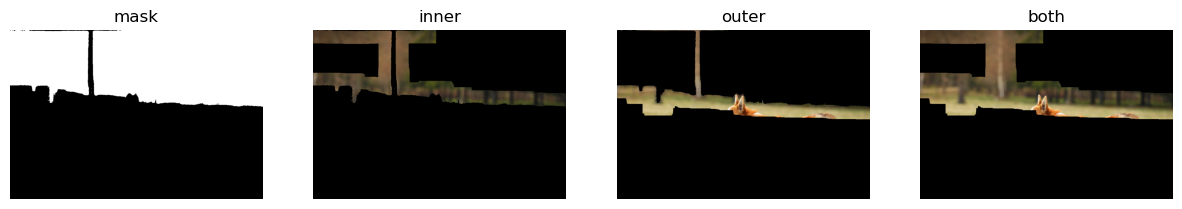

In [8]:
border_thickness = 100
mm = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
inner = apply_border_mask(image, mask, border_thickness, 'inner')
outer = apply_border_mask(image, mask, border_thickness, 'outer')
both = apply_border_mask(image, mask, border_thickness, 'both')
plot_images([mm, inner, outer, both], ['mask', 'inner', 'outer', 'both'], 15)


# Select Style

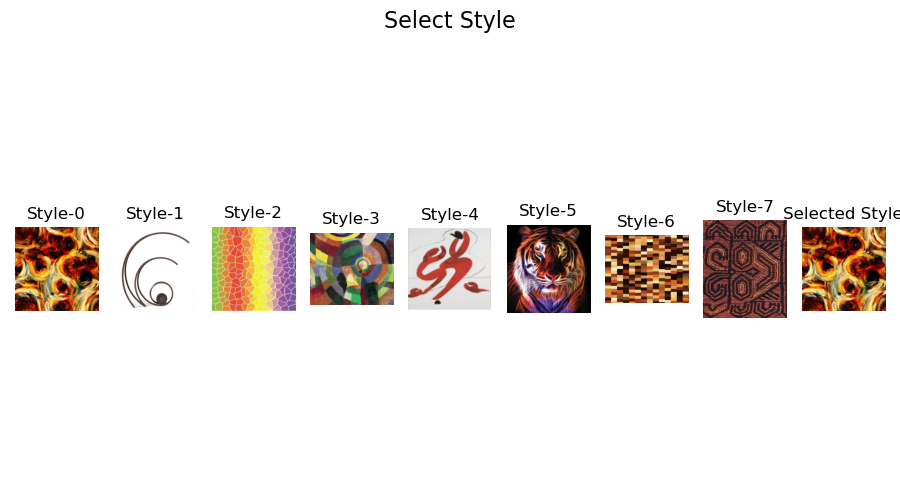

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import display
import ipywidgets as widgets

style_images = [cv2.cvtColor(cv2.imread(f'./styles/style-{i}.jpg'), cv2.COLOR_BGR2RGB) for i in range(8)]

interactive_fig_styles, axs = plt.subplots(1, 9, figsize=(9, 5))
interactive_fig_styles.suptitle('Select Style', fontsize=16)

image_titles = ['Style-0', 'Style-1', 'Style-2', 'Style-3', 'Style-4', 'Style-5', 'Style-6', 'Style-7', 'Selected Style']

for i, ax in enumerate(axs[:-1]):
    ax.imshow(style_images[i])
    ax.set_title(image_titles[i])
    ax.axis('off')

ax_st_selected = axs[-1]
implot_st_selected = ax_st_selected.imshow(style_images[0])
ax_st_selected.set_title(image_titles[-1])
ax_st_selected.axis('off')
style_image_file = f'./styles/style-0.jpg'

def onclick_style(event):
    global style_image_file
    for i, ax in enumerate(axs[:-1]):
        if event.inaxes == ax:
            axs[-1].clear() 
            axs[-1].imshow(style_images[i])
            axs[-1].set_title(image_titles[-1]) 
            axs[-1].axis('off')
            style_image_file = f'./styles/style-{i}.jpg'
            break
    interactive_fig_styles.canvas.draw_idle()

interactive_fig_styles.canvas.mpl_connect('button_press_event', onclick_style)

plt.tight_layout() 
plt.show()

# Select Algorithm

In [9]:
algorithms=['Style And Mask', 'Mask And Style', 'BBox Style and Mask', 'BBox Mask and Style', 'Partial Convolution']
dropdown = widgets.Dropdown(
    options=algorithms,  
    value='Partial Convolution',
    description='Algorithm:',
    disabled=False,
)
display(dropdown)

Dropdown(description='Algorithm:', index=4, options=('Style And Mask', 'Mask And Style', 'BBox Style and Mask'…

# Process

Partial Convolution processing...
Total Style Loss: 623.8946533203125
7 - 114.99 - 84.31 - 87.41 - 0.009238798171281815 - 0.007826519198715687 - 0.0170653173699975


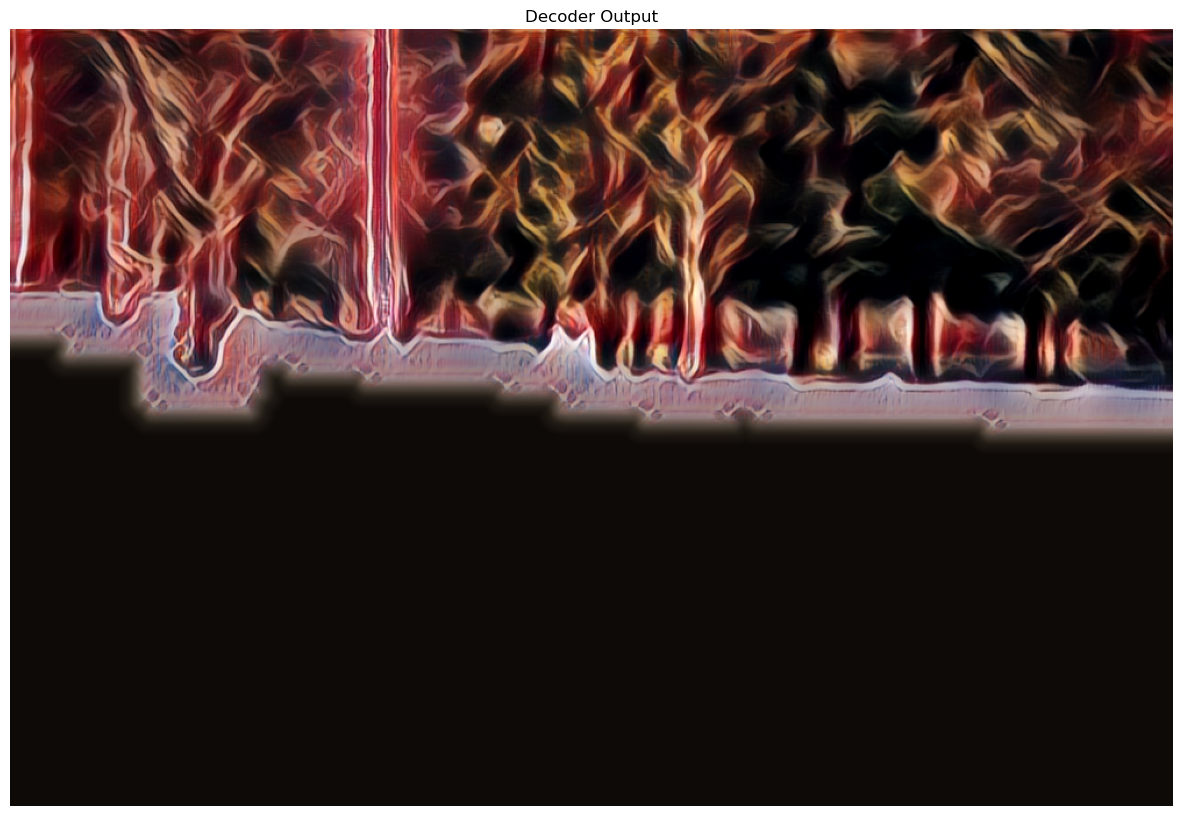

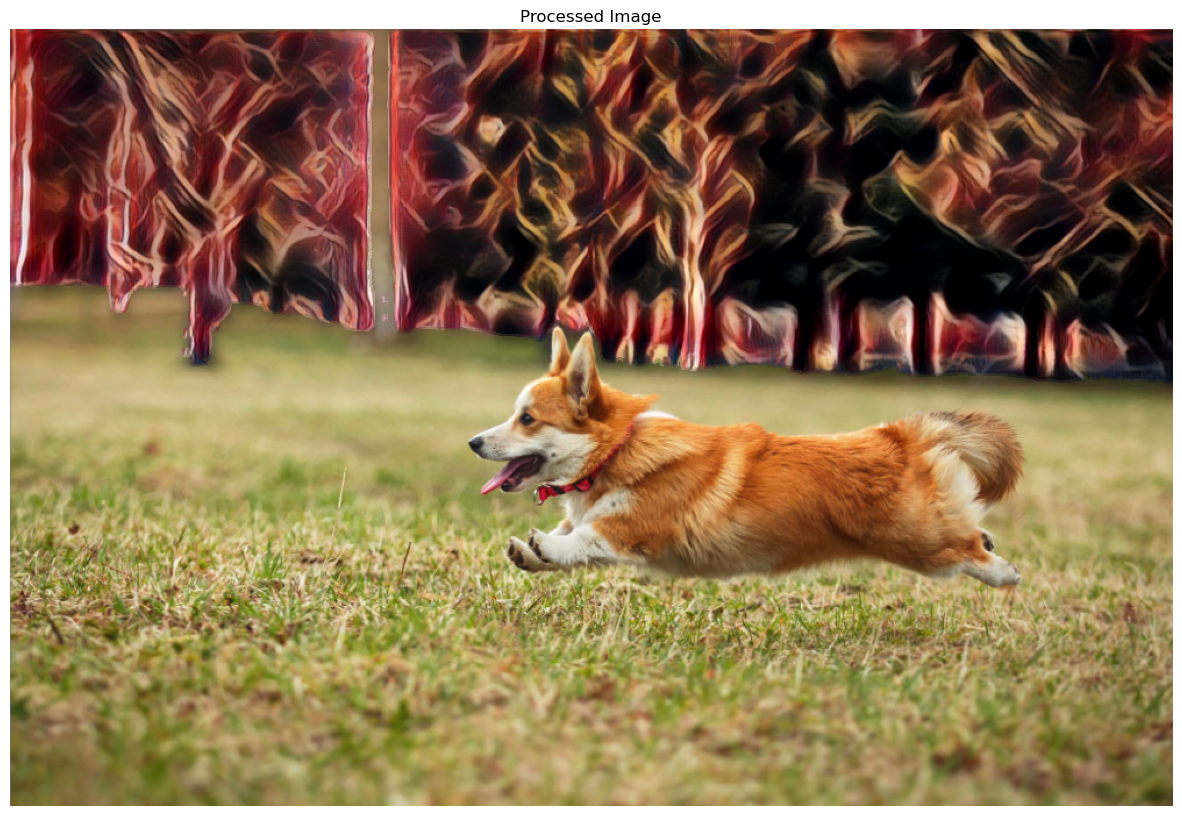

In [19]:
#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload

import sys
if 'libs.Matrix' in sys.modules:
    del sys.modules['libs.Matrix']
if 'libs.models' in sys.modules:
    del sys.modules['libs.models']
if 'libs.Matrix_masked' in sys.modules:
    del sys.modules['libs.Matrix_masked']
if 'libs.models_masked' in sys.modules:
    del sys.modules['libs.models_masked']
    
from libs import Matrix, models, Matrix_masked, models_masked
from libs.Matrix import MulLayer
from libs.models import encoder4, decoder4
from libs.Matrix_masked import MulLayer as MulLayer_m
from libs.models_masked import encoder4 as encoder_m, decoder4 as decoder_m

import numpy as np

selected_index = dropdown.index
algorithm = algorithms[selected_index]
print(f'{algorithm} processing...')

processed_image_filename = 'processed_image.jpg'

os.remove('processed_image.jpg')

if os.path.isfile(processed_image_filename):
    image_to_be_processed = cv2.imread(processed_image_filename)
else:
    image_to_be_processed = cv2.imread(original_image_name)
    
cF_ref=None; sF_ref=None

if selected_index == 0:
    processed_image = style_and_mask(image_to_be_processed, mask, style_image_file)
elif selected_index == 1:
    processed_image = mask_and_style(image_to_be_processed, mask, style_image_file)
elif selected_index == 2:
    processed_image = bbox_style_and_mask(image_to_be_processed, mask, style_image_file)
elif selected_index == 3:
    processed_image = bbox_mask_and_style(image_to_be_processed, mask, style_image_file)
elif selected_index == 4:
    processed_image = partial_convolution(
        image_to_be_processed, 
        mask, 
        style_image_file, 
        original_feature_sum=False,
        feathering=True, 
        penetrate_initial_mask_pixels=9,
        cookie_cutter=True
    )
    #processed_image = partial_convolution_feathering(image_to_be_processed, mask, style_image_file)
    
processed_image_rgb = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
cv2.imwrite('processed_image.jpg', processed_image_rgb) 

mask_borders_inner = get_mask_borders(mask, 5, 0)
mask_borders       = get_mask_borders(mask, 0, 5)
mask_borders_outer = get_mask_borders(mask, 5, 10)

mean, std, median = calculate_gradient_magnitude_around_border(processed_image_rgb, get_mask_borders(mask, 2, 5))
texture_continuity_1 = calculate_texture_continuity(processed_image_rgb, mask_borders_inner, mask_borders)
texture_continuity_2 = calculate_texture_continuity(processed_image_rgb, mask_borders, mask_borders_outer)
sum_text_continuity = texture_continuity_1 + texture_continuity_2

print(f'{i} - {round(mean, 2)} - {round(std, 2)} - {round(median, 2)} - {texture_continuity_1} - {texture_continuity_2} - {sum_text_continuity}')

plot_images([processed_image], ['Processed Image'], 15)


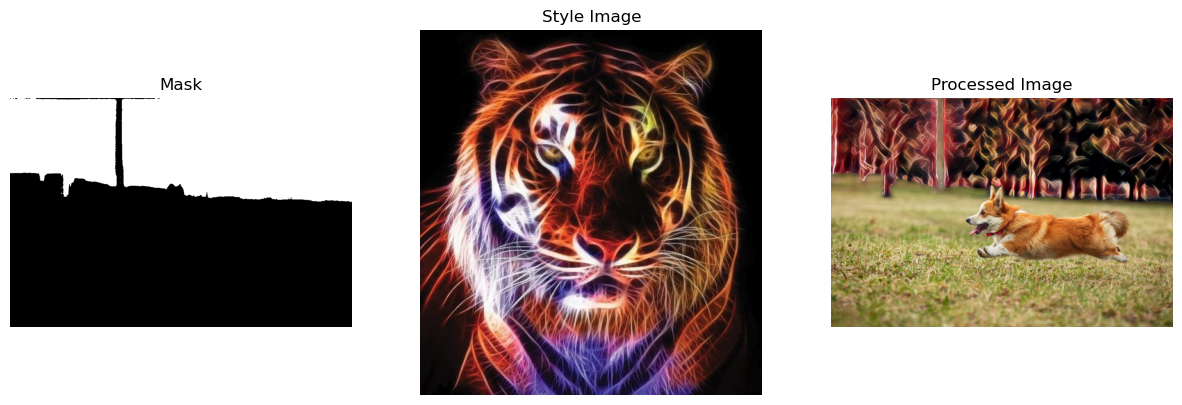

In [11]:
style_image = cv2.imread(style_image_file)
style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)

styled_image = cv2.imread('processed_image.jpg')
styled_image = cv2.cvtColor(styled_image, cv2.COLOR_BGR2RGB)

mask_image = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
 
plot_images([mask_image, style_image, styled_image], ['Mask', 'Style Image', 'Processed Image'], 15)

# Style Image Statistics

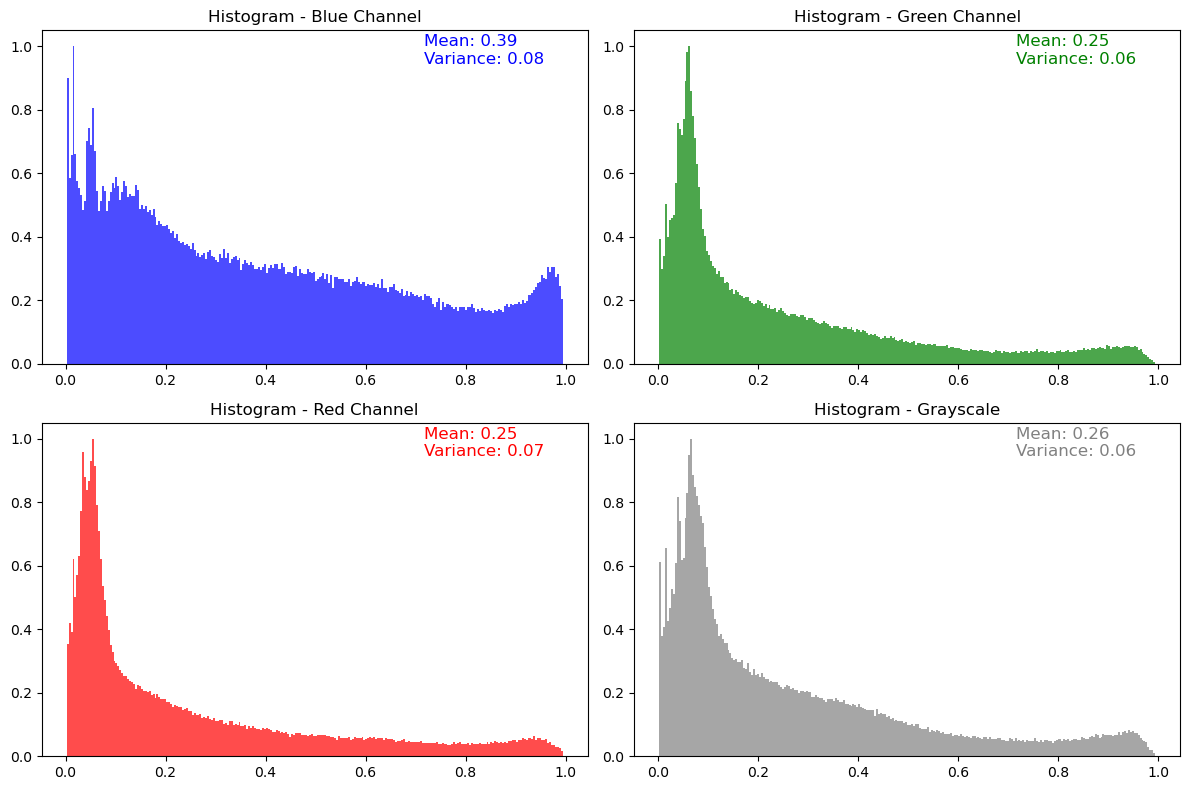

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 

def process_channels(image):
    # Normalize Blue, Green, Red, and Grayscale channels
    blue_channel_vals = image[:, :, 0].flatten() / 255.0
    green_channel_vals = image[:, :, 1].flatten() / 255.0
    red_channel_vals = image[:, :, 2].flatten() / 255.0
    gray_channel_vals = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).flatten() / 255.0

    # Exclude black (0) and white (1) pixels after normalization
    blue_channel_vals = blue_channel_vals[(blue_channel_vals > 0) & (blue_channel_vals < 1)]
    green_channel_vals = green_channel_vals[(green_channel_vals > 0) & (green_channel_vals < 1)]
    red_channel_vals = red_channel_vals[(red_channel_vals > 0) & (red_channel_vals < 1)]
    gray_channel_vals = gray_channel_vals[(gray_channel_vals > 0) & (gray_channel_vals < 1)]

    # Calculate mean and variance for each channel
    mean_blue, var_blue = np.mean(blue_channel_vals), np.var(blue_channel_vals)
    mean_green, var_green = np.mean(green_channel_vals), np.var(green_channel_vals)
    mean_red, var_red = np.mean(red_channel_vals), np.var(red_channel_vals)
    mean_gray, var_gray = np.mean(gray_channel_vals), np.var(gray_channel_vals)

    return (blue_channel_vals, mean_blue, var_blue), (green_channel_vals, mean_green, var_green), \
           (red_channel_vals, mean_red, var_red), (gray_channel_vals, mean_gray, var_gray)

def plot_normalized_histogram(data, bins, color, title, mean, variance):
    counts, bin_edges = np.histogram(data, bins=bins)
    counts_normalized = counts / counts.max()  # Normalize so max value is 1
    plt.bar(bin_edges[:-1], counts_normalized, width=np.diff(bin_edges), color=color, alpha=0.7)
    plt.title(title)
    plt.text(0.7, 0.9, f'Mean: {mean:.2f}\nVariance: {variance:.2f}', transform=plt.gca().transAxes, fontsize=12, color=color)

(blue_style, mean_blue, var_blue), (green_style, mean_green, var_green), \
(red_style, mean_red, var_red), (gray_style, mean_gray, var_gray) = process_channels(style_image)

# Plot the histograms for BGR channels and Grayscale in a 2x2 grid
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plot_normalized_histogram(blue_style, bins=254, color='blue', title='Histogram - Blue Channel', mean=mean_blue, variance=var_blue)

plt.subplot(2, 2, 2)
plot_normalized_histogram(green_style, bins=254, color='green', title='Histogram - Green Channel', mean=mean_green, variance=var_green)

plt.subplot(2, 2, 3)
plot_normalized_histogram(red_style, bins=254, color='red', title='Histogram - Red Channel', mean=mean_red, variance=var_red)

plt.subplot(2, 2, 4)
plot_normalized_histogram(gray_style, bins=254, color='gray', title='Histogram - Grayscale', mean=mean_gray, variance=var_gray)

plt.tight_layout()
plt.show()

# Styled Image Statistics

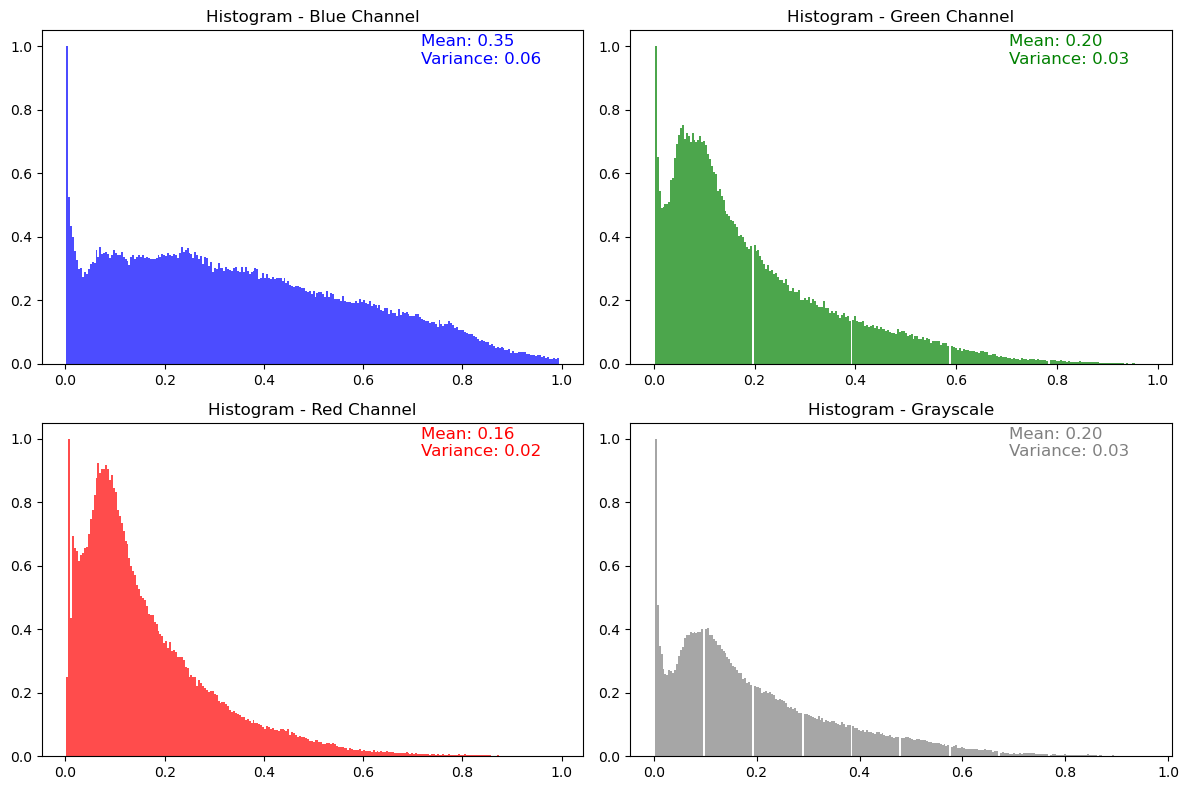

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming mask and styled_image are defined

mask_active = mask > 0
rows, cols = mask_active.shape
num_pixels = np.count_nonzero(mask_active)

# Extract and normalize pixel values from the masked region for each color channel (BGR)
blue_styled = styled_image[mask_active][:, 0] / 255.0  # Normalize Blue channel
green_styled = styled_image[mask_active][:, 1] / 255.0  # Normalize Green channel
red_styled = styled_image[mask_active][:, 2] / 255.0  # Normalize Red channel

# Convert to grayscale, apply the mask, and normalize
gray_img_vals = cv2.cvtColor(styled_image, cv2.COLOR_BGR2GRAY)
gray_styled = gray_img_vals[mask_active] / 255.0  # Normalize Grayscale values

# Exclude black (0) and white (1) pixels after normalization
blue_styled = blue_styled[(blue_styled > 0) & (blue_styled < 1)]
green_styled = green_styled[(green_styled > 0) & (green_styled < 1)]
red_styled = red_styled[(red_styled > 0) & (red_styled < 1)]
gray_styled = gray_styled[(gray_styled > 0) & (gray_styled < 1)]

# Calculate mean and variance for each channel
mean_blue_channel, var_blue_channel = np.mean(blue_styled), np.var(blue_styled)
mean_green_channel, var_green_channel = np.mean(green_styled), np.var(green_styled)
mean_red_channel, var_red_channel = np.mean(red_styled), np.var(red_styled)
mean_gray_channel, var_gray_channel = np.mean(gray_styled), np.var(gray_styled)

# Function to plot normalized histograms
def plot_normalized_histogram(data, bins, color, title, mean, variance):
    counts, bin_edges = np.histogram(data, bins=bins)
    counts_normalized = counts / counts.max()  # Normalize so max value is 1
    plt.bar(bin_edges[:-1], counts_normalized, width=np.diff(bin_edges), color=color, alpha=0.7)
    plt.title(title)
    plt.text(0.7, 0.9, f'Mean: {mean:.2f}\nVariance: {variance:.2f}', transform=plt.gca().transAxes, fontsize=12, color=color)

# Plot the histograms for BGR channels and Grayscale in a 2x2 grid
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plot_normalized_histogram(blue_styled, bins=254, color='blue', title='Histogram - Blue Channel', mean=mean_blue_channel, variance=var_blue_channel)

plt.subplot(2, 2, 2)
plot_normalized_histogram(green_styled, bins=254, color='green', title='Histogram - Green Channel', mean=mean_green_channel, variance=var_green_channel)

plt.subplot(2, 2, 3)
plot_normalized_histogram(red_styled, bins=254, color='red', title='Histogram - Red Channel', mean=mean_red_channel, variance=var_red_channel)

plt.subplot(2, 2, 4)
plot_normalized_histogram(gray_styled, bins=254, color='gray', title='Histogram - Grayscale', mean=mean_gray_channel, variance=var_gray_channel)

plt.tight_layout()
plt.show()

In [14]:
from scipy.stats import wasserstein_distance

bins = 256
blue_hist1, _ = np.histogram(blue_style, bins=bins, range=(0, 1), density=True)
green_hist1, _ = np.histogram(green_style, bins=bins, range=(0, 1), density=True)
red_hist1, _ = np.histogram(red_style, bins=bins, range=(0, 1), density=True)
gray_hist1, _ = np.histogram(gray_style, bins=bins, range=(0, 1), density=True)

blue_hist2, _ = np.histogram(blue_styled, bins=bins, range=(0, 1), density=True)
green_hist2, _ = np.histogram(green_styled, bins=bins, range=(0, 1), density=True)
red_hist2, _ = np.histogram(red_styled, bins=bins, range=(0, 1), density=True)
gray_hist2, _ = np.histogram(gray_styled, bins=bins, range=(0, 1), density=True)

# Calculate EMD between corresponding channels of the two images
emd_blue = wasserstein_distance(blue_hist1, blue_hist2)
emd_green = wasserstein_distance(green_hist1, green_hist2)
emd_red = wasserstein_distance(red_hist1, red_hist2)
emd_gray = wasserstein_distance(gray_hist1, gray_hist2)

# Print EMD values
print(f"Blue channels: {round(emd_blue, 2)}")
print(f"Green channels: {round(emd_green, 2)}")
print(f"Red channels: {round(emd_red, 2)}")
print(f"Grayscale channels: {round(emd_gray, 2)}")

Blue channels: 0.21
Green channels: 0.31
Red channels: 0.42
Grayscale channels: 0.28


In [17]:
import numpy as np
import cv2
from scipy.stats import wasserstein_distance

def calculate_emd(style_image, styled_image, mask):
    bins = 256
    
    def get_channel_vals(image, mask=None):
        if mask is not None:
            mask_active = mask > 0
            blue = image[mask_active][:, 0] / 255.0
            green = image[mask_active][:, 1] / 255.0
            red = image[mask_active][:, 2] / 255.0
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)[mask_active] / 255.0
        else:
            blue = image[:, :, 0].flatten() / 255.0
            green = image[:, :, 1].flatten() / 255.0
            red = image[:, :, 2].flatten() / 255.0
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).flatten() / 255.0

        # Exclude black and white pixels
        blue = blue[(blue > 0) & (blue < 1)]
        green = green[(green > 0) & (green < 1)]
        red = red[(red > 0) & (red < 1)]
        gray = gray[(gray > 0) & (gray < 1)]

        return blue, green, red, gray

    # Channel values for style and styled images
    blue_style, green_style, red_style, gray_style = get_channel_vals(style_image)
    blue_styled, green_styled, red_styled, gray_styled = get_channel_vals(styled_image, mask)

    # Compute histograms
    hist_style = [np.histogram(c, bins=bins, range=(0, 1), density=True)[0] for c in [blue_style, green_style, red_style, gray_style]]
    hist_styled = [np.histogram(c, bins=bins, range=(0, 1), density=True)[0] for c in [blue_styled, green_styled, red_styled, gray_styled]]

    # Calculate EMD
    emd_values = [wasserstein_distance(hist_style[i], hist_styled[i]) for i in range(4)]

    channel_names = ['Blue', 'Green', 'Red', 'Grayscale']
    for name, emd in zip(channel_names, emd_values):
        print(f"{name} channel EMD: {round(emd, 2)}")

calculate_emd(style_image, styled_image, mask)       


Blue channel EMD: 0.21
Green channel EMD: 0.31
Red channel EMD: 0.42
Grayscale channel EMD: 0.28
